In [28]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
    torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape # torch.Size([1500, 5])，1500个样本，每个样本5个特征

torch.Size([1500, 5])

为了让输入参数变得更通用（为后续小节的实现作铺垫），

这里添加了一个状态输入states并将超参数放在字典hyperparams里。

此外，我们将在训练函数里对各个小批量样本的损失求平均，因此优化算法里的梯度不需要除以批量大小。

In [5]:
# optimizer
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

# 实现一个通用的训练函数
始化一个线性回归模型，然后这个模型可以使用小批量随机梯度下降或者后续其他算法来训练模型。

In [15]:
def train_ch7(optimizer_fn,states,hyperparams,features,labels,
              batch_size=10,num_epochs=2):
    # 初始化模型，就一个全连接层
    net, loss = d2l.linreg, d2l.squared_loss
    
    # w:(5,1)
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0,0.01,size=(features.shape[1],1)),dtype=torch.float32),
                          requires_grad=True)
    # b:(1)
    b = torch.nn.Parameter(torch.zeros(1,dtype=torch.float32),requires_grad=True)
    
    # 计算平均的损失
    def eval_loss():
        return loss(net(features,w,b),labels).mean().item()
    
    ls = [eval_loss()]
    
    # 数据提供，一次提供一个批量的数据和对应的标签
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features,labels),batch_size,shuffle=True
    )
    
    for _ in range(num_epochs):
        start = time.time()
        # 读取小批量，批量大小自定义
        # batch_size = 1，表示随机梯度下降
        # batch_size = 训练集大小， 表示梯度下降
        # 其余情况就是小批量随机梯度下降
        for batch_i,(X,y) in enumerate(data_iter):
            l = loss(net(X,w,b),y).mean() # 使用平均损失
            
            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            
            # 反向传播之后，每个参数的.grad属性都有了值
            l.backward()
            
            # 更新参数：[w,b]，具体更新的方式定义在了optimizer_fn函数里面
            # 这里hyperparams = {'lr':lr}
            optimizer_fn([w,b],states,hyperparams) 
            
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
            
    # 打印结果和作图        
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    # 创建等差数列：首尾分别为0和num_epochs，长度为len(ls)
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

In [10]:
# def train_ch7(optimizer_fn,states,hyperparams,features,labels,
#              batch_size=10,num_epochs=2):

def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

当批量大小为1500时，优化使用的是梯度下降

loss: 0.244076, 0.012647 sec per epoch


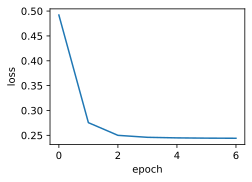

In [16]:
train_sgd(1, 1500, 6)

当批量大小为1时，优化使用的是随机梯度下降。为了简化实现，有关（小批量）随机梯度下降的实验中，我们未对学习率进行自我衰减，而是直接采用较小的常数学习率。随机梯度下降中，每处理一个样本会更新一次自变量（模型参数），一个迭代周期里会对自变量进行1,500次更新。

loss: 0.245413, 0.377137 sec per epoch


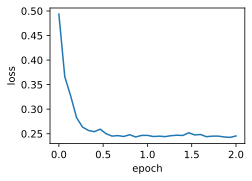

In [17]:
train_sgd(0.005, 1)

当批量大小为10时，优化使用的是小批量随机梯度下降。它在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。

loss: 0.244537, 0.045965 sec per epoch


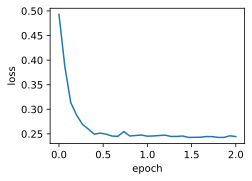

In [19]:
train_sgd(0.05, 10)


# 随机梯度下降的简单实现

In [58]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features,labels,
                     batch_size=10,num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[1],1)
    )
    
    # 定义损失函数
    loss = nn.MSELoss()
    
    # 定义优化器
    optimizer = optimizer_fn(net.parameters(),**optimizer_hyperparams)
    
    
    def eval_loss():
        # net(features)输出形状为（1500，1）的二维Tensor
        # net(features).view(-1)后变换为长度为1500的一维Tensor，和labels形状正好对应
        return loss(net(features).view(-1), labels).item()/2
    
    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels),batch_size,shuffle=True
    )
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_id, (X,y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1),y) / 2
            
            # 1.梯度清零
            optimizer.zero_grad()
            # 2.反向传播
            l.backward()
            # 3.更新参数
            optimizer.step()
            
            if (batch_id + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

In [52]:
net = nn.Sequential(
        nn.Linear(features.shape[1],1)
    )
print(type(net(features)))
print(net(features).shape)
print(net(features).view(-1).shape)
print(type(labels))

<class 'torch.Tensor'>
torch.Size([1500, 1])
torch.Size([1500])
<class 'torch.Tensor'>


loss: 0.242808, 0.059905 sec per epoch


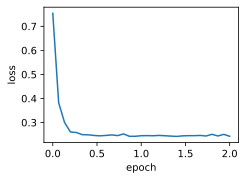

In [60]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, batch_size=10)